# Colorimetric sensing array image processing for real time multianalyte 
# concentration monitoring.
# Code run on raspberry Pi and Python 3.X
# Author: Zijian Du

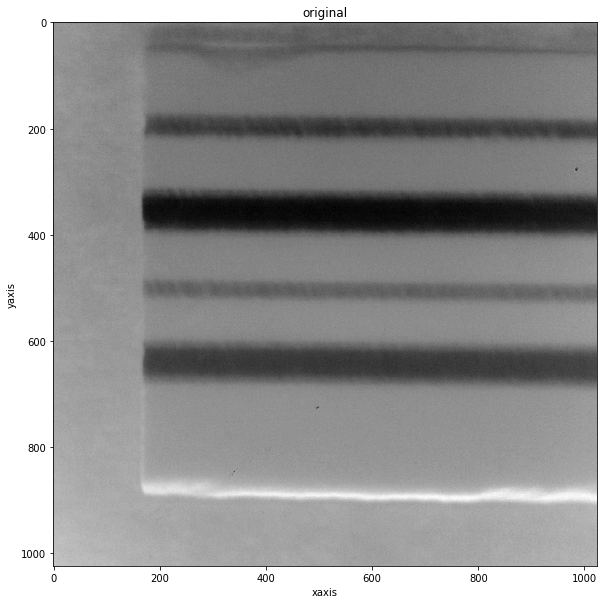

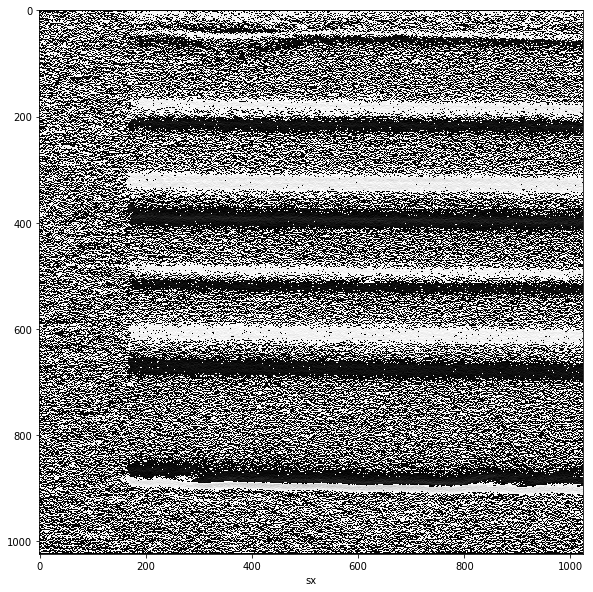

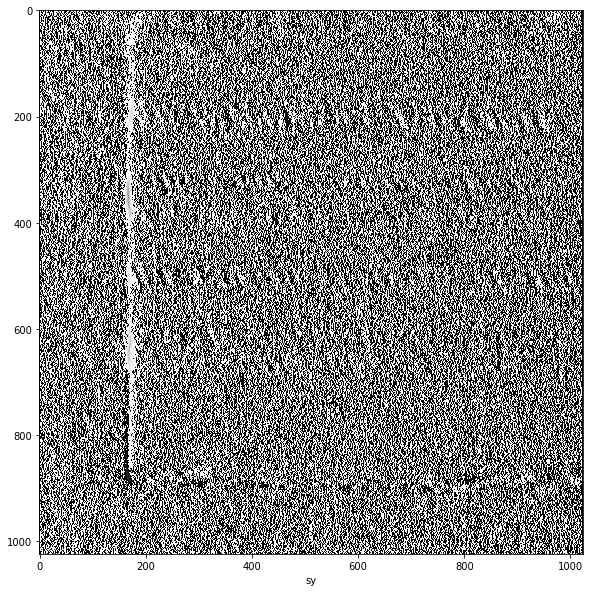

position for sensor 1
175
position for sensor 2
169
position for sensor 3
171
position for sensor 4
172


In [118]:
from time import sleep
#from picamera import PiCamera
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np
from scipy import ndimage
from sklearn.cluster import spectral_clustering
import scipy as sp
from sklearn.feature_extraction import image
from skimage import feature

'''
camera = PiCamera()
camera.resolution = (1024,1024)
camera.start_preview()
sleep(10)
camera.capture('test_light.jpg')
camera.stop_preview()

'''
# image processing

picture = mpimg.imread('test_1.jpg')
picture_channel = picture[:,:,0]
picture_channel = picture_channel.astype(np.uint8)

# approach 1: known sensor trace location

sensor1 = picture_channel[170:220,:]
sensor2 = picture_channel[320:400,:]
sensor3 = picture_channel[480:530,:]
sensor4 = picture_channel[620:660,:]
plt.figure(figsize = (10,10))
plt.imshow(picture_channel, cmap=plt.cm.gray)
plt.xlabel('xaxis')
plt.ylabel('yaxis')
plt.title('original')
plt.show()

# approach 2: use sobel edge detector for automatic edge tracking
sx=ndimage.sobel(picture_channel, axis=0, mode='mirror')
sy=ndimage.sobel(picture_channel, axis=1, mode='mirror')

plt.figure(figsize=(10,10))
plt.imshow(sx, cmap = plt.cm.gray)
plt.xlabel('sx')
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(sy, cmap = plt.cm.gray)
plt.xlabel('sy')
plt.show()



'''
# approach 3: use canny edge detector:
# smoothing, finding gradient(sobel), nonmaximum supression, double thresholding
# edge tracking
edge1 = feature.canny(picture_channel)
edge2 = feature.canny(picture_channel, sigma = 0.01)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(edge1)
ax1.axis('off')
ax1.set_title('edge1', fontsize=20)

ax2.imshow(edge2, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('edge2', fontsize=20)

fig.tight_layout()

plt.show()
'''




# average the whole sensor area along the y axis

sensor_intensity = np.zeros((4,1024))
for i in range(1024):
    sensor_intensity[0, i] = np.mean(sensor1[:, i])
    sensor_intensity[1, i] = np.mean(sensor2[:, i])
    sensor_intensity[2, i] = np.mean(sensor3[:, i])
    sensor_intensity[3, i] = np.mean(sensor4[1, i])

sensor_intensity = sensor_intensity.astype(np.float16)



# define a function that return the calculated sensor edge position

def get_position(sensor_intensity):
    
# obtain the intensity max and min in sensor1 area
    sensor_min = np.amin(sensor_intensity)
    sensor_max = np.amax(sensor_intensity)
    sensor_mean = (sensor_max + sensor_min)/2
    idx = (np.abs(sensor_intensity-sensor_mean)).argmin()

    # do not need these if we have only one single position for the mean value
    #while idx >= sensor_min_index:
     #   sensor_intensity = np.delete(sensor_intensity, idx)
      #  idx = (np.abs(sensor_intensity - sensor_mean)).argmin()
    return idx


for i in range(4):
    print("position for sensor", i+1)
    print(get_position(sensor_intensity[i,:]))
    





In [115]:
# define colorimetric_sensor class
class colorimetric_sensor:
    '''
    colorimetric_sensor class which have various chemical concentrations, temperature and humidity
    process the image and obtain the concentration of chemicals in real time
    '''
    def __init__(self):
        self.expire = False
        self.O3=0
        self.HCHO=0
        self.NO2=0
        self.humidity=0
        self.temperature=0
        self.time=0
    # locate the common edges for colorimetric sensors
    def get_edge(self, image, position_1, position_2, position_3, threshold_precent, window_size):
        # initialize computed edge positions as empty list
        edge = []
        common_edge = []
        # initialize smoothed_signal as shape(3, image.shape[0]) 2D array
        smoothed_signal = np.ndarray(shape=(3, image.shape[0]), dtype=np.float16)
        # maximum and minimum are the maximum and minimum intensity along three positions on the image
        maximum = [np.max(image[:, position_1]), np.max(image[:, position_2]), np.max(image[:, position_3])]
        minimum = [np.min(image[:, position_1]), np.min(image[:, position_2]), np.min(image[:, position_3])]
        # edge_level is the threshold_precent multiply sum of max and min
        edge_level = [y+threshold_precent*(x-y) for (x, y) in zip(maximum, minimum)]
        edge_level = np.array(edge_level).astype(np.float16)
      
        # now we do a moving average filtering for the signal to reduce(remove) the gitters(noise) which may 
        # cause ambiguity of edge positions
        window = np.ones(int(window_size))/float(window_size)
        # smooth the three signals
        smoothed_signal[0,:] = np.convolve(image[:, position_1], window, 'same')
        smoothed_signal[1,:] = np.convolve(image[:, position_2], window, 'same')
        smoothed_signal[2,:] = np.convolve(image[:, position_3], window, 'same')
        # now delete the first and last portions of signal due to convolution
        smoothed_signal = smoothed_signal[:, int(window_size/2):smoothed_signal.shape[1]-int(window_size/2)]
        #return smoothed_signal
        # now find the position(index) of the edge by using hard thresholding: oneside above(below), 
        # the other size below(above) threshold, there should be four corssing points
        for j in range(smoothed_signal[0,:].shape[0]-1):
            # this means that there is a crossing for the val
            if (smoothed_signal[0,j]-edge_level[0])*(smoothed_signal[0, j+1]-edge_level[0])<0:
                edge.append(j)
        for j in range(smoothed_signal[1,:].shape[0]-1):
            if (smoothed_signal[1,j]-edge_level[1])*(smoothed_signal[1, j+1]-edge_level[1])<0:
                edge.append(j)
        for j in range(smoothed_signal[2,:].shape[0]-1):
            if (smoothed_signal[2,j]-edge_level[2])*(smoothed_signal[2, j+1]-edge_level[2])<0:
                edge.append(j)
        if len(edge) != 12:
            print("can not find all edges, try changing threshold_precent!")
        common_edge = edge
        # now we want to find the edge for the sensors, pick the min/max among the three values for each identified edge
        return edge_level, smoothed_signal, common_edge
    # get_intensity: get the intensity change profile along the identified sensor strip
    def get_intensity(self, image, common_edge, position_1, position_3):
        # intialize final averaged sensor_intensity
        sensor_intensity=np.empty(shape=[2,image.shape[1]], dtype = np.float16)
        # if the sensor is in good position (max of one edge is smaller than min of the other edge)
        if max(common_edge[0], common_edge[4], common_edge[8]) < min(common_edge[1], common_edge[5], common_edge[9]):
            final_edge = []
            # obtain the mean of the intensity value using identified edges
            final_edge.append(np.max([edge[0], edge[4], edge[8]]))
            final_edge.append(np.min([edge[1], edge[5], edge[9]]))
            final_edge.append(np.max([edge[2], edge[6], edge[10]]))
            final_edge.append(np.min([edge[3], edge[7], edge[11]]))
            for i in range(2):
                sensor_intensity[i] = np.mean(image[final_edge[2*i]:final_edge[2*i+1],:],axis=0)
        # in this case the max of one edge is larger than min of the other edge, can not average horizontally. 
        # rotation: change of coordinate, rescaling problem. Instead use geometry to draw lines parallel to the sensor traces
        # position two dots, draw line, choose the range of width and obtain the average along the drawn line
        else:
            sensor1_center = [], sensor2_center = []
            sensor1_center.append(int((edge[0]+edge[1])/2)), sensor1_center.append(int((edge[8]+edge[9])/2))
            sensor2_center.append(int((edge[2]+edge[3])/2)), sensor2_center.append(int((edge[10]+edge[11])/2))
            # now determine the width of the drawn edges, should contain two elements
            width = []
            width.append(min(edge[1]-edge[0], edge[9]-edge[8]))
            width.append(min(edge[3]-edge[2], edge[11]-edge[10]))
            for i in range(2):
                for j in range(image.shape[1]):
                    middle = position_1-(position_1-i)*(sensor1_center[1]-sensor1_center[0])/(position_3-position_1)
                    lower = int(middle - 0.5*width[i])
                    higher = int(middle + 0.5*width[i])
                    sensor_intensity[i,j] = np.mean(image[lower:higher, j])
        return sensor_intensity          
            
            
    # get_position: identify the position of the sensor edge given the intensity profile
    def get_position(self, sensor_intensity):
        # do a slight smoothing for sensor intensity first before looking for the position
        # obtain the intensity max and min in sensor1 area
        idx = []
        sensor_min = np.amin(sensor_intensity, axis = 1)
        sensor_max = np.amax(sensor_intensity, axis = 1)
        sensor_mean = (sensor_max + sensor_min)/2
        for i in range(2):
            idx.append(np.abs(sensor_intensity[i,:]-sensor_mean[i]).argmin())
        return sensor_max, sensor_intensity, idx

In [116]:
sensor = colorimetric_sensor()
# why are there more than 8 positions here?? need to find out
edge_level, X, common_edge=sensor.get_edge(picture_channel[100:450,:], 300, 500, 700, 0.6, 6)
common_edge[0]

77

In [117]:
sensor_intensity = sensor.get_intensity(picture_channel[100:450,:], common_edge, 300, 700)
sensor_max, sensor_intensity, idx=sensor.get_position(sensor_intensity)
print(sensor_intensity.shape)
print(edge_level)
print(X[0,:])
print(edge)
print(common_edge)
print(sensor_intensity.shape)
print(sensor_max)
print(idx)

(2, 1024)
[ 80.625   80.1875  81.    ]
[ 100.5      100.1875   100.5      100.8125   100.6875   100.5      100.1875
  100.3125   100.3125   100.5      100.6875   101.1875   101.6875   102.1875
  102.1875   102.3125   102.5      102.8125   103.       102.1875   101.8125
  101.8125   101.8125   101.6875   101.8125   101.6875   102.1875   102.
  102.1875   102.       102.3125   103.3125   103.1875   103.5      103.
  102.8125   102.1875   101.5      101.5      101.1875   101.3125   101.5
  101.5      101.6875   102.       102.6875   102.6875   102.6875   102.8125
  102.6875   102.6875   102.1875   102.       102.6875   102.5      102.5
  102.3125   102.5      102.8125   101.8125   101.6875   101.3125   101.
  100.        98.8125    98.5       97.5       96.6875    95.        93.3125
   92.1875    90.6875    89.        87.3125    85.8125    84.5       82.8125
   81.3125    79.5       77.        74.8125    73.3125    71.1875    69.3125
   68.1875    68.3125    68.5       68.3125    68.3125 

In [12]:
a = np.array([[1,2,3]])
a-0.6


array([[ 0.4,  1.4,  2.4]])

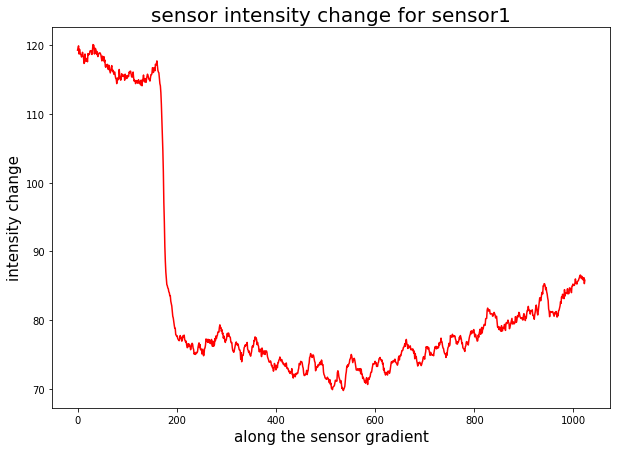

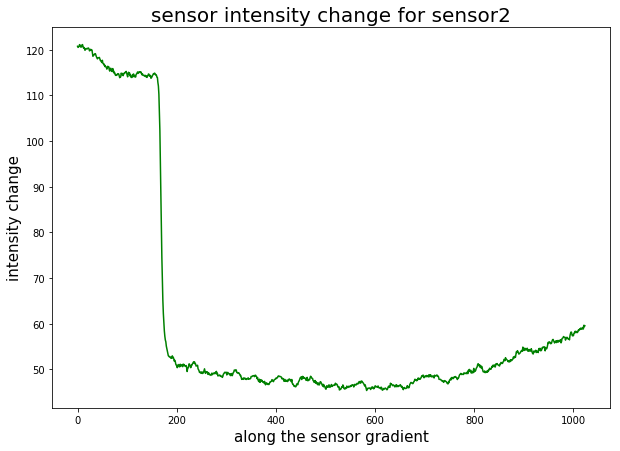

In [13]:
# plot the averaged sensor intensity along the direction of gradient
plt.figure(figsize = (10,7))
plt.plot(sensor_intensity[0,:], color = 'r')
plt.xlabel("along the sensor gradient", fontsize=15)
plt.ylabel("intensity change", fontsize=15)
plt.title("sensor intensity change for sensor1", fontsize=20)
plt.show()
plt.figure(figsize = (10,7))
plt.plot(sensor_intensity[1,:], color = 'green')
plt.xlabel("along the sensor gradient", fontsize=15)
plt.ylabel("intensity change", fontsize=15)
plt.title("sensor intensity change for sensor2", fontsize=20)
plt.show()


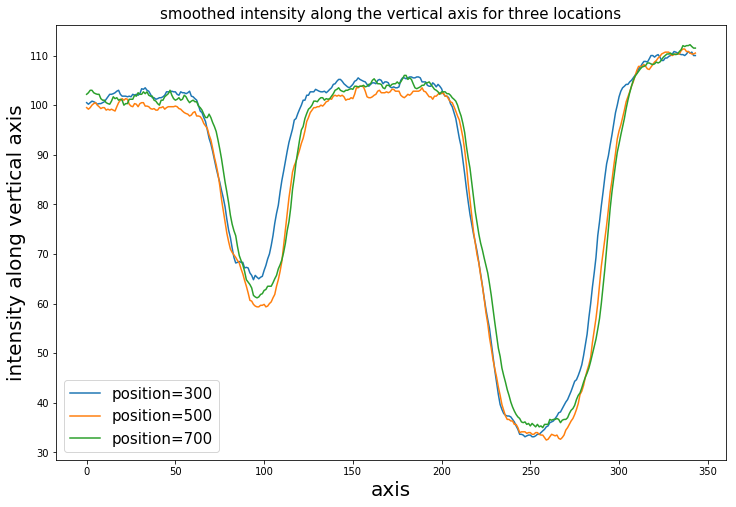

In [14]:
plt.figure(figsize = (12, 8))
plt.plot(X[0,:], label = "position=300")
plt.plot(X[1,:], label="position=500")
plt.plot(X[2,:], label="position=700")
plt.xlabel("axis", fontsize = 20)
plt.ylabel("intensity along vertical axis", fontsize = 20)
plt.title("smoothed intensity along the vertical axis for three locations", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()


In [15]:
sensor = colorimetric_sensor()
X, edges =sensor.get_intensity(picture_channel[100:450], 300, 500, 700, 0.7, 1)
plt.figure(figsize = (12, 8))
plt.plot(X[0,:], label = "position=300")
plt.plot(X[1,:], label="position=500")
plt.plot(X[2,:], label="position=700")
plt.xlabel("axis", fontsize = 20)
plt.ylabel("intensity along vertical axis", fontsize = 20)
plt.title("un-smoothed intensity along the vertical axis for three locations", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()
X[0,:].shape

TypeError: get_intensity() takes 5 positional arguments but 7 were given

In [16]:
np.unique(sy)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  55,  56,  57,  59,  61,  62,  67,  68,  69,  71,  72,
        73,  74,  75,  77,  78,  83,  86,  90,  95,  98, 101, 102, 103,
       115, 118, 120, 122, 128, 129, 132, 133, 139, 140, 141, 143, 146,
       149, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 24

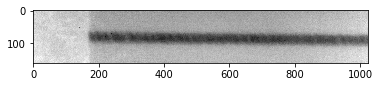

(160, 1024)

In [17]:
sensor = picture_channel[420:580,:]
plt.imshow(sensor, cmap = plt.cm.gray)
plt.show()
sensor.shape

# try using self defined sobel filter to extract the gradient
# try using sobel filter in ndimage package to extract the gradient

In [18]:
# implement sobel filter assuming two dimensional image
from scipy import signal
def sobel_filter(im, k_size):
    assert(k_size==3 or k_size==5)
    if k_size==3:
        kh=np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float)
        kv=np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float)
    else:
        kh = np.array([[-1, -2, 0, 2, 1], 
                   [-4, -8, 0, 8, 4], 
                   [-6, -12, 0, 12, 6],
                   [-4, -8, 0, 8, 4],
                   [-1, -2, 0, 2, 1]], dtype = np.float)
        kv = np.array([[1, 4, 6, 4, 1], 
                   [2, 8, 12, 8, 2],
                   [0, 0, 0, 0, 0], 
                   [-2, -8, -12, -8, -2],
                   [-1, -4, -6, -4, -1]], dtype = np.float)
    gx=signal.convolve2d(im, kh, mode='same', boundary='symm', 
                         fillvalue=0)
    gy=signal.convolve2d(im, kv, mode='same', boundary='symm',
                        fillvalue=0)
    g=np.sqrt(gx*gx+ gy*gy)
    g = g*255.0/np.max(g)
    return g.astype(np.uint8)

In [19]:
s_5=sobel_filter(sensor, 5)
s_3=sobel_filter(sensor,3)

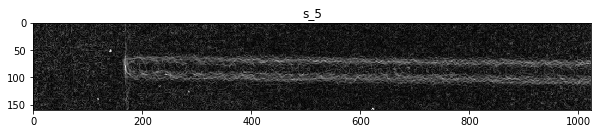

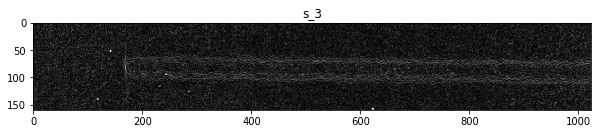

In [20]:
plt.figure(figsize = (10, 4))
plt.imshow(s_5, cmap=plt.cm.gray)
plt.title('s_5')
plt.show()
plt.figure(figsize=(10,4))
plt.imshow(s_3, cmap=plt.cm.gray)
plt.title('s_3')
plt.show()


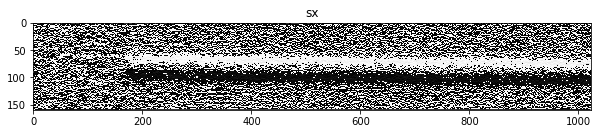

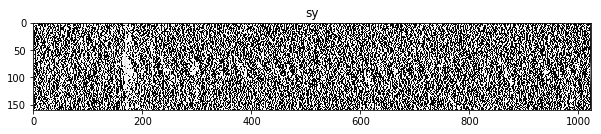

In [21]:
# sobel results using ndimage.sobel() method
sx=ndimage.sobel(sensor, axis=0, mode= 'constant')
sy=ndimage.sobel(sensor,axis=1, mode = 'constant')
plt.figure(figsize = (10, 4))
plt.imshow(sx, cmap=plt.cm.gray)
plt.title('sx')
plt.show()
plt.figure(figsize=(10,4))
plt.imshow(sy, cmap=plt.cm.gray)
plt.title('sy')
plt.show()


In [22]:
a = np.array([[1,2,3],[0,10,100]])
np.amin(a, axis =1)

array([1, 0])

In [23]:
a = np.array([[1,1],[2,2]])
a.resize([3,3])
a

array([[1, 1, 2],
       [2, 0, 0],
       [0, 0, 0]])

In [56]:
picture_channel_rotate = ndimage.interpolation.rotate(picture_channel, angle = -5, reshape = False, mode='constant')
print(picture_channel_rotate.shape)
print(picture_channel.shape)

(1024, 1024)
(1024, 1024)


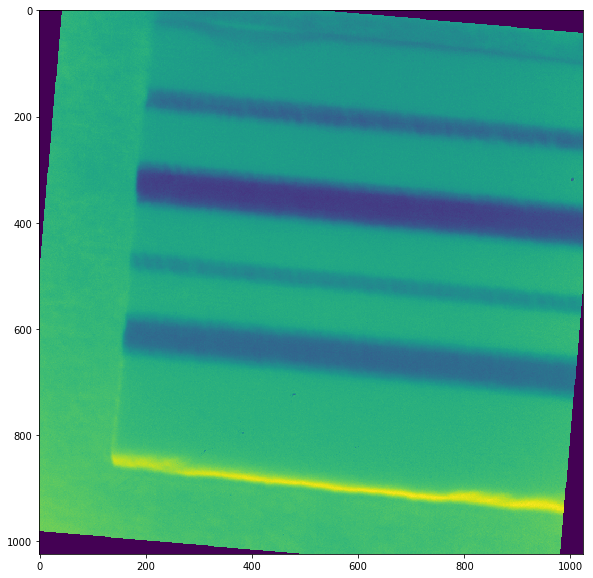

array([  0,   0,   0, ..., 112, 111, 113], dtype=uint8)

In [57]:
plt.figure(figsize = (10, 10))
plt.imshow(picture_channel_rotate)
plt.show()
picture_channel_rotate[200, :]

In [112]:
a = [[1,2,3],[2,3,4],[3,4,5]]
a = np.array(a)
np.mean(a[0:1,2])

3.0

In [114]:
max(2,3)

AxisError: axis 3 is out of bounds for array of dimension 0